<a href="https://colab.research.google.com/github/kevinkyuen/projects/blob/main/Power_Outages_Logistic_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Severe Weather Event Prediction: Logistic Regression Model Analysis**

#Kevin Yuen





---









#**Objective**:

Our goal for this project is to observe past real-world data and gather insights to assist Southern California Edison in predicting severe weather. Our study begins with our dataset, which includes major power outage events in the United States between January 2000 to July 2016. Understanding the risk that severe weather presents to a power grid’s reliability is a quintessential study that SoCal Edison can use to predict and protect their own power grid from severe weather in the future.

#**Stakeholder**: SoCal Edision

#Import Libaries

In this step, it is important to import all the necessary libaries for data handling, preprocessing, visuilizaing, and modeling

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import statsmodels.api as sm


#Load the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv("/content/FINAL_DATA.csv")


#Inspect The Data

In [ ]:
# Print out the first 5 rows of our dataset; this shows all column names that we're dealing with and the first 5 rows
df.head()

,month,seasons,anomaly_level,day_of_week,part_of_day,severe_weather,outage_duration,residential,commercial,industrial
0,7,Summer,-0.3,Friday,Evening,1,3060,2332915,2114774,2113291
1,5,Spring,-0.1,Sunday,Evening,0,1,1586986,1807756,1887927
2,10,Autumn,-1.5,Tuesday,Evening,1,3000,1467293,1801683,1951295
3,6,Summer,-0.1,Tuesday,Night,1,2550,1851519,1941174,1993026
4,7,Summer,1.2,Saturday,Night,1,1740,2028875,2161612,1777937


In [ ]:
# Check to see column type, counts, and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            1463 non-null   int64  
 1   seasons          1463 non-null   object 
 2   anomaly_level    1463 non-null   float64
 3   day_of_week      1463 non-null   object 
 4   part_of_day      1463 non-null   object 
 5   severe_weather   1463 non-null   int64  
 6   outage_duration  1463 non-null   int64  
 7   residential      1463 non-null   int64  
 8   commercial       1463 non-null   int64  
 9   industrial       1463 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 114.4+ KB


In [ ]:
# Check for the count of rows and columns
df.shape

(1463, 10)

Dataset has 1463 rows and 10 coulmns

# Data Preprocessing

Logistic regression models, like the one we will create for our dataset, are heavily reilaint on the data that they are given to train on. Thus, we need to ensure that the data that is being given to these models can are within a certain range of usability, whether it be that there are no duplicates, null values, outliers, or higher-level linkages between values, such as multicolinearlity (the direct relationship between two dataset columns that can impact the way an LR model predicts and understands the information given).

In the following steps, we will go over several data preprocessing steps to increase the accuracy and predictability of our logistic regression model.

#Check for Missing Values

In [ ]:
# Scans through the rows of the dataset to check for nulls
df.isna().sum()

month              0
seasons            0
anomaly_level      0
day_of_week        0
part_of_day        0
severe_weather     0
outage_duration    0
residential        0
commercial         0
industrial         0
dtype: int64

We found no null values, meaning no values need to be dropped from our dataset

#Check For Outliers



Outliers pose a great threat to machine learning algorithms. Because they operate solely on the knowledge gained from the data its fed, data that skews it too far in either direction (too large or too small) can make the model less effective in predicting values. Some of the ways these models can be affected by outliers include distorted data distribution, overfitting, increased training time, and reduced model effectiveness.

In [ ]:
# Calculate the Z-scores for each column in the dataset
# Gets numerical columns from df, calculates each column's z-score, then stores them in variable "z_scores" to use later
z_scores = stats.zscore(df.select_dtypes(include=[float, int]))

In [ ]:
# Set a threshold for identifying outliers, which in our case is three standard deviations from the mean
threshold = 3

In [ ]:
# Find the absolute Z-scores that are greater than the threshold
# Creates a new variable "outliers" that checks to see if our values from "z_scores" is outside our "threshhold" of three standard deviations
outliers = (np.abs(z_scores) > threshold)

In [ ]:
# Print the number of outliers in each column
print("Number of outliers in each column:")
print(np.sum(outliers, axis=0))

Number of outliers in each column:
month               0
anomaly_level      23
severe_weather      0
outage_duration    20
residential        28
commercial          0
industrial          8
dtype: int64


Four of the columns from our dataset contain values that are *at least* `three standard deviations` away from the mean; these values can be found in 'anomaly_level', 'outage_duration', 'residential', and 'industrial.'

We will remove these in the following step.

#Remove Outliers

As previously mentioned, we need to remove the outliers in the four columns that contain outliers. Because of this, we use the `stats` library once again check for z-scores are greater than three. If this is the case, they are removed from our dataset.

In [ ]:
# Remove rows with outliers in 'anomaly_level', 'outage_duration', 'residential', and 'industrial'
# Uses our previously created dataframe df, checks whether or not the z-scores are over
df = df[(np.abs(stats.zscore(df['anomaly_level'])) < 3) &
        (np.abs(stats.zscore(df['outage_duration'])) < 3) &
        (np.abs(stats.zscore(df['residential'])) < 3) &
        (np.abs(stats.zscore(df['industrial'])) < 3)]


In [ ]:
df.shape

(1389, 10)

After removing the outliers, the dataset now has 1389 rows and 10 columns.

#Scaling Numerical Features

As we continue preprocessing our data, we move onto `scaling` to make our model's values more coherent and linear for the model to understand. This takes place through the use of `Standard Scaler`, a technique that is used to change values from their column-dependent values to ones values that are specific values away from the standard deviation.

This allows the model to process the weight of certain values away from their given mean, something similar to "leveling the playing field" for each column in the dataset.

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns to scale, all numerical values. We will use categorical variables in a later step
columns_to_scale = ['month', 'anomaly_level', 'outage_duration', 'residential', 'commercial', 'industrial']

# Scale the numerical columns; changes the values in the columns to the previously mentioned "distance away from the standard deviation"
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Display the first few rows after scaling
print(df.head())


      month seasons  anomaly_level day_of_week part_of_day  severe_weather  \
0  0.229985  Summer      -0.216677      Friday     Evening               1   
1 -0.375606  Spring       0.089026      Sunday     Evening               0   
2  1.138371  Autumn      -2.050890     Tuesday     Evening               1   
3 -0.072810  Summer       0.089026     Tuesday       Night               1   
4  0.229985  Summer       2.076090    Saturday       Night               1   

   outage_duration  residential  commercial  industrial  
0         0.265426    -0.598950   -0.641745   -0.266218  
1        -0.642642    -0.852427   -0.734427   -0.377502  
2         0.247615    -0.893100   -0.736260   -0.346211  
3         0.114032    -0.762535   -0.694151   -0.325605  
4        -0.126417    -0.702267   -0.627606   -0.431815  


#Correlation Matrix

Also known as a "heatmap," a correlation matrix shows the relationship between numerical values (categorical variables cannnot be passed through).

With a correlation matrix, we can find and look for columns in our dataset that are directly correlated; if two columns are linked together (in that both are either directly or indirectly correlated to each other), the model being built will have trouble predicting future values.

- **+1:** Indicates a perfect positive correlation, meaning as one variable increases, the other increases proportionally.
- **-1:** Indicates a perfect negative correlation, meaning as one variable increases, the other decreases proportionally.
- **0:** Represents no linear correlation, implying the changes in one variable don't influence the other in a predictable way.
- **Values between -1 and +1:** Reflect varying degrees of positive or negative correlation. The closer the value is to 1 (positive) or -1 (negative), the stronger the linear relationship.

In [ ]:
# Define the columns to include in the correlation matrix
columns_for_correlation = [
    'month', 'anomaly_level', 'severe_weather', 'outage_duration',
    'residential', 'commercial', 'industrial'
]

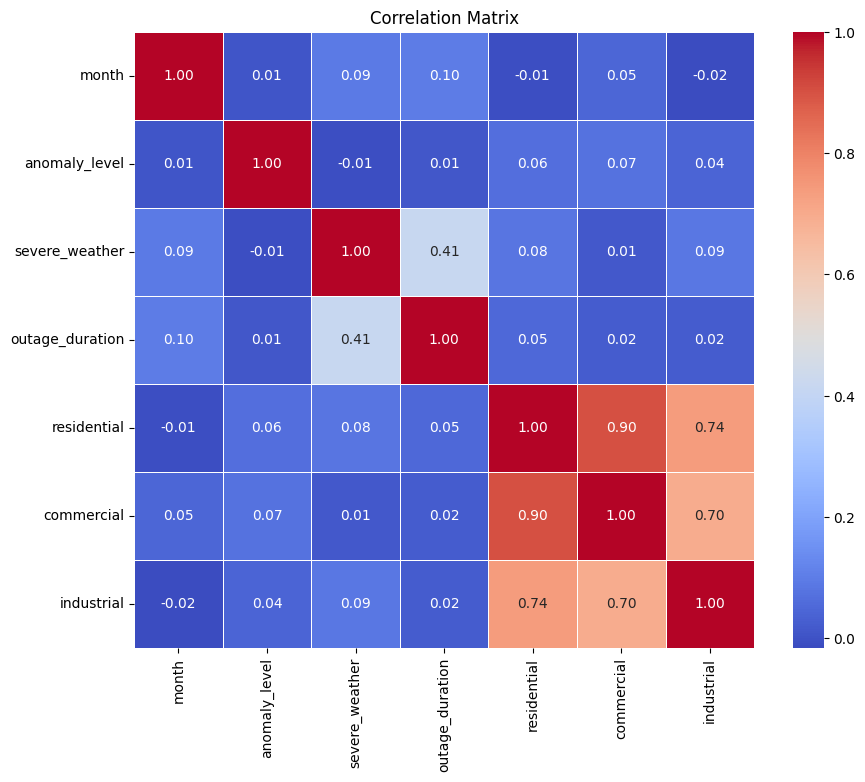

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df[columns_for_correlation].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#Create Dummy Variables

In this step, we change all the categorical variables that cannot be placed on a scale into variabels that can be used for our regression model. the `get_dummies` function changes the categorical values into "1" or "0" for the entire column; with each newly created column, see each occurance replaced with a 1 and every other value replaced with a 0.

For example, a column that contains only names of season names would be split into four: the created columns would appear as "seasons_(Spring/Summer/Winter)".

In the scenario listed above, the column "seasons_Autumn" is missing; in fact, one of the columns for each of our categorical variables is removed in each of the exmaples to avoid `perfect multicolinearity`. This makes it so that our model can better identify independent variables that are statistically significant to our dataset.



In [ ]:
# Convert categorical variables to dummy variables
df_with_dummies = pd.get_dummies(df, columns=['seasons', 'day_of_week', 'part_of_day'], drop_first=True)

# Display the first few rows of the new dataframe with dummy variables
print(df_with_dummies.head())


      month  anomaly_level  severe_weather  outage_duration  residential  \
0  0.229985      -0.216677               1         0.265426    -0.598950   
1 -0.375606       0.089026               0        -0.642642    -0.852427   
2  1.138371      -2.050890               1         0.247615    -0.893100   
3 -0.072810       0.089026               1         0.114032    -0.762535   
4  0.229985       2.076090               1        -0.126417    -0.702267   

   commercial  industrial  seasons_Spring  seasons_Summer  seasons_Winter  \
0   -0.641745   -0.266218               0               1               0   
1   -0.734427   -0.377502               1               0               0   
2   -0.736260   -0.346211               0               0               0   
3   -0.694151   -0.325605               0               1               0   
4   -0.627606   -0.431815               0               1               0   

   day_of_week_Monday  day_of_week_Saturday  day_of_week_Sunday  \
0            

#Splitting the Dataset

Splitting the dataset is a quintessential part of making a model. We want to ensure that the model actually performs properly with the data it's given **and** with new data, so we divide the dataset into `training` and `testing` sets. The training set is what the model uses to learn from and generate predictions, whereas the testing set is used to confirm whether or not those predictions generated from the training set are accurate.

In the code below, we split the dataset by giving the testing set 40% of the data, leaving the rest of the 60% to the training set.


In [ ]:
# Define the target variable 'y' and the features 'X'
y = df_with_dummies['severe_weather'] # gets the column 'severe weather' from dataframe "df_with_dummies" and assigns it the dataframe y. This will be our target variable we use for predictions
X = df_with_dummies.drop(['severe_weather'], axis=1) # With a similar layout as the function above, this creates a new dataframe X, but removes ONLY the column 'severe_weather' to better isolate our target variable

# Split the dataset into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)

# Display the shape of the training and testing sets
print("Training set shape:", train_X.shape)
print("Testing set shape:", test_X.shape)


Training set shape: (833, 18)
Testing set shape: (556, 18)


#Building and Training the Logistic Regression Model

Create and train a logistic regression model using the training data.



In [ ]:
# Initialize the logistic regression model
logit_reg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=1) # uses the LR function to create the model, sets basic settings for the regularization, solver, and random state

# Train the model
logit_reg.fit(train_X, train_y)

# Print the intercept and coefficients of the model
print('Intercept:', logit_reg.intercept_)
print('Coefficients:', logit_reg.coef_)


Intercept: [0.00584248]
Coefficients: [[ 0.09298214 -0.01413329  1.39408087  0.42526421 -0.60724549  0.29727661
  -0.62889012 -0.02068413 -0.23279636  0.09969592  0.36545563  0.49907994
  -0.35376809 -0.23300336  0.16226403  1.11915602 -0.15953287  0.8493678 ]]


Regularization --> Penalty = '12'
- This tells the model to use 'ridge regularization', a method used to penalize the model for having higher coefficients. This is done through adding a "regularization term" that is added to the regularization equation that serves to reduce the higher coefficients.

Strength --> 'C=1.0'
- This controls the strength of the regularization penalty specified above. With a higher value of C, a stronger penalty that is placed on the model to reduce overfitting.

Solver --> 'solver='liblinear'
- This specifies the algorithm 'liblinear' to be used for our logistic regression model.

Random State --> 'random_state=1'
- This sets a random seed for the model, using the randomness to ensure the predictability of the model to output the same results every time it's run.

#What Do These Coefficients Mean?

The coefficients in a logistic regression model represent the strength and direction of the association between each feature and the likelihood of the target variable, severe weather. A positive coefficient means that as the feature value increases, the probability of severe weather occurring also increases, and vice versa for a negative coefficient.



#Check Model Performance

How did the model perform on both training and testing set?


In [ ]:
# Predictions on the training set
train_predictions = logit_reg.predict(train_X) # uses the data from logit_reg and makes predictions off those (from our training dataset)

# Predictions on the testing set
test_predictions = logit_reg.predict(test_X) # similar to the code above, we use the data from logit.reg to see the predicted values from test_x

In [ ]:
# Classification report and confusion matrix for the training set
print("Training Set Evaluation:")
print(confusion_matrix(train_y, train_predictions))
print(classification_report(train_y, train_predictions))

Training Set Evaluation:
[[333  83]
 [116 301]]
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       416
           1       0.78      0.72      0.75       417

    accuracy                           0.76       833
   macro avg       0.76      0.76      0.76       833
weighted avg       0.76      0.76      0.76       833



In [ ]:
# Classification report and confusion matrix for the testing set
print("Testing Set Evaluation:")
print(confusion_matrix(test_y, test_predictions))
print(classification_report(test_y, test_predictions))

Testing Set Evaluation:
[[220  50]
 [ 89 197]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       270
           1       0.80      0.69      0.74       286

    accuracy                           0.75       556
   macro avg       0.75      0.75      0.75       556
weighted avg       0.76      0.75      0.75       556



The two sets (testing and training) perform generally well when placed against each other. The training set sees an accuracy of 75%, whereas the training set sees an accuracy of 73.3%. Ideally, both models would be more accurate when predicting values, but both are similar in terms of how accurate they are in general.

#Feature Selection

Refine the model by selecting statistically significant features based on p-values.




In [ ]:
# Add a constant to the features for the statsmodels logistic regression
X_with_const = sm.add_constant(X) # A constant term is added to fit the model to a line, giving it more flexibility to ascertain the relationship between dependent and independent variables.

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, X_with_const).fit()

Optimization terminated successfully.
         Current function value: 0.523098
         Iterations 7


#Check P-Values

In [ ]:
# Print the summary to check p-values
print(logit_model.summary())


                           Logit Regression Results                           
Dep. Variable:         severe_weather   No. Observations:                 1389
Model:                          Logit   Df Residuals:                     1370
Method:                           MLE   Df Model:                           18
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:                  0.2452
Time:                        01:51:21   Log-Likelihood:                -726.58
converged:                       True   LL-Null:                       -962.68
Covariance Type:            nonrobust   LLR p-value:                 7.234e-89
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1911      0.271      0.705      0.481      -0.340       0.722
month                     0.0477      0.084      0.571      0.568      -0.116       0.212
anomaly_

# P-Value Interpretation

p-value < 0.05: The predictor is considered statistically significant, meaning there is strong evidence that its coefficient is different from zero. This variable has a meaningful impact on the outcome (severe weather in this case).

p-value >= 0.05: The predictor is not considered statistically significant at
the 5% significance level. This suggests that the variable may not have a strong impact on the outcome, or its effect is not reliably different from zero in this dataset.

`outage_duration` has a p-value of 0.000, indicating it is highly significant.

`residential`, `commercial`, `industrial`, `seasons_Spring`, `day_of_week_Sunday`, `part_of_day_Evening`, and `part_of_day_Night`also have p-values below 0.05, making them significant predictors.

# Build a New Model With The Significant Features

While we initially set out to remove all columns with a p-value less than 10, we found that **all columns** saw z-scores less than 10. Thus, we targeted z-scores less than 10 to increase the specificity being fed to our logistic regression model in hopes for a more reliable outcome.

In [ ]:
# Define a list of variables to remove based on their p-values that are greater than 0.05
variables_to_remove = [
    'month', 'anomaly_level', 'seasons_Summer', 'seasons_Winter',
    'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Thursday',
    'day_of_week_Tuesday', 'day_of_week_Wednesday', 'part_of_day_Morning'
]

In [ ]:
# Drop the variables from the features DataFrame
X_refined = X.drop(variables_to_remove, axis=1)

In [ ]:
# Split the refined dataset into training and testing sets
train_X_refined, test_X_refined, train_y_refined, test_y_refined = train_test_split(
    X_refined, y, test_size=0.4, random_state=1
)
# Similar to our training and testing sets before, we want to use this newly-refined dataframe for the same process as we did before.

In [ ]:
# Refit the logistic regression model with the refined features
logit_reg_refined = LogisticRegression(max_iter=1000)
logit_reg_refined.fit(train_X_refined, train_y_refined)

LogisticRegression(max_iter=1000)

In [ ]:
# Predictions on the refined training and testing sets
train_predictions_refined = logit_reg_refined.predict(train_X_refined)
test_predictions_refined = logit_reg_refined.predict(test_X_refined)

In [ ]:
# Evaluate the refined model
print("Refined Model Evaluation:")
print("Training Set:")
print(confusion_matrix(train_y_refined, train_predictions_refined))
print(classification_report(train_y_refined, train_predictions_refined))
print("Testing Set:")
print(confusion_matrix(test_y_refined, test_predictions_refined))
print(classification_report(test_y_refined, test_predictions_refined))

Refined Model Evaluation:
Training Set:
[[334  82]
 [122 295]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.77       416
           1       0.78      0.71      0.74       417

    accuracy                           0.76       833
   macro avg       0.76      0.76      0.75       833
weighted avg       0.76      0.76      0.75       833

Testing Set:
[[228  42]
 [ 90 196]]
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       270
           1       0.82      0.69      0.75       286

    accuracy                           0.76       556
   macro avg       0.77      0.76      0.76       556
weighted avg       0.77      0.76      0.76       556



#Interpret the metrics

* Accuracy: The model is correct about 76% of the time in predicting whether a severe weather event will occur.

* Precision: The model is more precise (around 78-82%) in predicting severe weather events compared to non-severe events (around 72-73%).

* Recall: The model is better at identifying non-severe weather events (80-84%) than severe weather events (69-71%).

* F1-score: The model has a good balance between precision and recall, with scores around 0.74-0.78.

The model performs well overall, with a slight advantage in identifying non-severe weather events



#Visualizing the Coefficients of the Refined Model

Now that we have a refined model that focuses in on **statistically significant** values, we can see the impact of each of those columns in the grand scheme of our model. This can show whether or not the predictors we chose have an important impact on the outcome of our model's predictions.

In [ ]:
#Get the coefficients from the logistic regression model
coefficients = logit_reg_refined.coef_[0]


In [ ]:
# Create a DataFrame to store the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': X_refined.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute values of the coefficients in descending order
sorted_coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

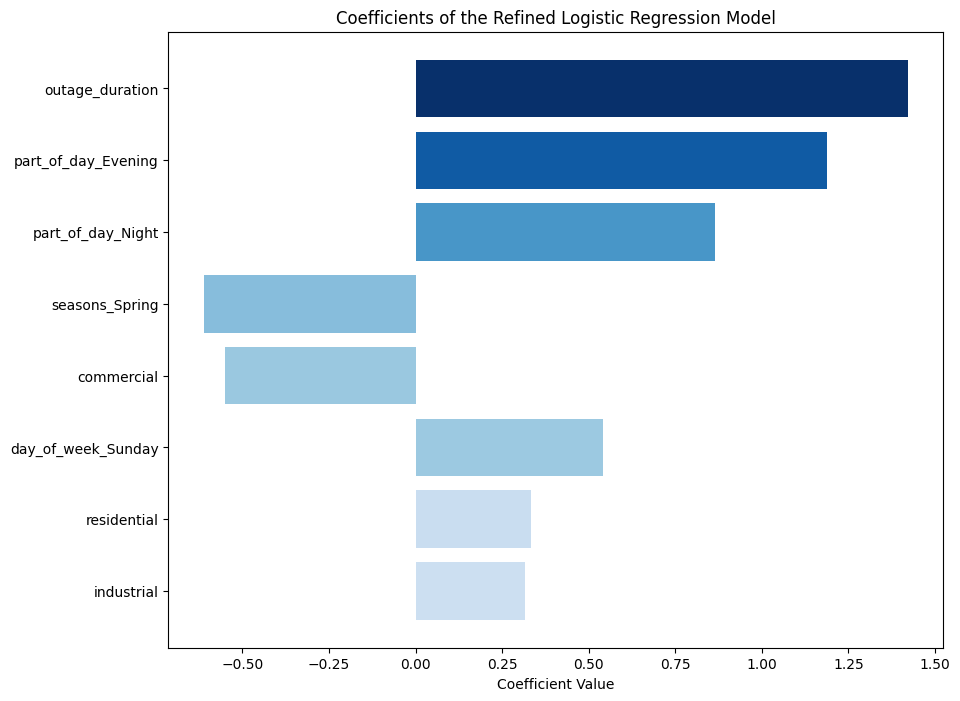

In [ ]:
# Creating a color map based on the coefficient values
colors = [plt.cm.Blues(np.abs(val) / max(np.abs(coefficients))) for val in sorted_coef_df['Coefficient']]

# Plot the coefficients as a bar chart
plt.figure(figsize=(10, 8))
plt.barh(sorted_coef_df['Feature'], sorted_coef_df['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Coefficients of the Refined Regression Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest coefficient on top
plt.show()

The chart helps in understanding which factors are considered more or less important by the model in predicting severe weather events

#Intreperation of this Graph:

`Outage Duration`: The longest bar going to the right shows that longer outage durations are strongly associated with an increased likelihood of severe weather. This is the most influential predictor in the model.

`Part of Day (Evening and Night)`: These bars also extend to the right, indicating that evening and night times have a positive relationship with severe weather occurrences compared to the reference part of the day (likely morning or afternoon).

`Season (Spring)`: The bar for Spring extends to the left, suggesting that the spring season is associated with a decreased likelihood of severe weather compared to the reference season (probably Autumn).

`Commercial`: The negative coefficient for commercial indicates that higher values in this predictor are associated with a lower likelihood of severe weather, compared to residential or industrial sectors.

`Day of Week (Sunday)`: Sunday has a positive coefficient, but less influential than outage duration, suggesting there is a higher likelihood of severe weather occurring on Sundays compared to the reference day of the week.



#Gains Chart and Lift Chart for the Refined Model


In [ ]:
# To create the gains chart and lift chart, we need to use the dmba package. Need to install it using pip:
!pip install dmba


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 32.5 MB/s eta 0:00:00


In [ ]:
from dmba import gainsChart, liftChart


Colab environment detected.


In [ ]:
# Compute the predicted probabilities for the positive class in the testing set
test_probabilities_refined = logit_reg_refined.predict_proba(test_X_refined)[:, 1]

In [ ]:
# Create a DataFrame for gains and lift charts
refined_results_df = pd.DataFrame({
    'actual': test_y_refined,
    'p(1)': test_probabilities_refined
})

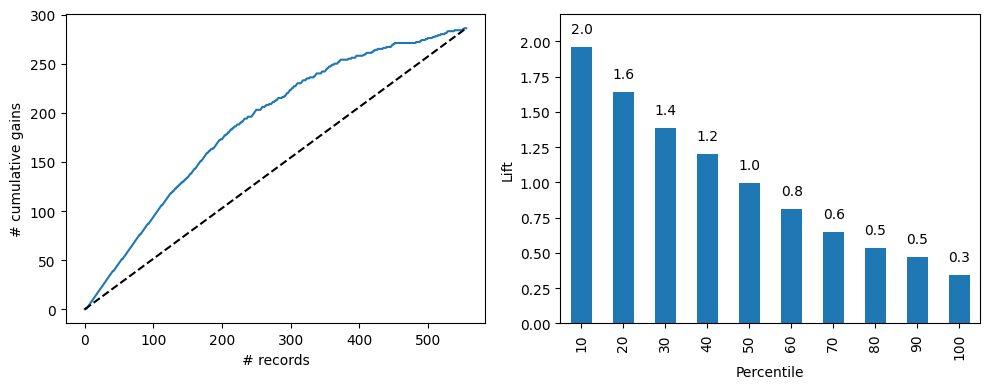

In [ ]:
# Sort the DataFrame by the probability of the positive class
refined_results_df = refined_results_df.sort_values(by='p(1)', ascending=False)

# Plot gains and lift charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(refined_results_df.actual, ax=axes[0])
liftChart(refined_results_df['p(1)'], title=False, ax=axes[1])
plt.tight_layout()
plt.show()

#What does the Gains Chart Show us?

* The Gains Chart compares the model against a random selection strategy.

* The x-axis represents the number of records, and the y-axis shows the cumulative gains (the number of positive outcomes).

* The blue line represents the model, and the dashed line represents random chance.

* If the blue line is above the dashed line, it indicates that the model is doing better than random chance in identifying positive outcomes.




#What does the lift chart show us?


* The Lift Chart shows how much better the model is at predicting positive outcomes compared to a random guess, at various percentiles of the data.

* The x-axis represents percentiles of the data, and the y-axis indicates the lift, which is the ratio of the results obtained with the model to the results from a random guess.

* Bars above 1 indicate that the model is doing better than random at that percentile.

* The first few bars are higher, showing that the model has good predictive power for the most likely positive outcomes. As we move to lower percentiles, the lift decreases, indicating less improvement over random guessing.


#Our conclusion

Overall,  our model does a reasonable job at predicting the occurances of severe weather. In both training and testing sets, we see a similar performance between the two, as both return accuracy numbers within 2% of each other. The model's performance is also reaffirmed through our gains and lift charts. In our gains chart, we see the model's performnace placed against that of random chamge; the model outperformns simple guessing, reliably predicting each occurance of severe weather more and more as the number of records increases. In our lift chart, we see that the the model does a good job at predicting positive outcomes in the tenth percentile.